# Supervised Learning

In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models - Not needed for this notebook
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# # Tensorflow
# import tensorflow as tf

# Pickle
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/processed/preprocessed.csv")
print(df.shape)
df.head()

(34299, 33)


,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Independent,AFFILIATION_Other,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C7000,CLASSIFICATION_Other,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,ORGANIZATION_Association,ORGANIZATION_Other,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.000000e+00,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
1,1.204843e-05,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0.000000e+00,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0
3,1.967945e-07,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,1.600293e-05,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [3]:
X = df.drop("IS_SUCCESSFUL", axis=1)
y = df["IS_SUCCESSFUL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# Function for Classification
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)

    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)

    train_results = f"""TRAIN METRICS
    Confusion Matrix:
    {train_cf}

    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """

    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)

    test_results = f"""TEST METRICS
    Confusion Matrix:
    {test_cf}

    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """

    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)

    # Set figure size
    plt.figure(figsize=(6, 6))

    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")

    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix:
    [[ 8033  4012]
 [ 3163 10516]]

    AUC: 0.7573048572543847

    Classification Report:
                  precision    recall  f1-score   support

           0       0.72      0.67      0.69     12045
           1       0.72      0.77      0.75     13679

    accuracy                           0.72     25724
   macro avg       0.72      0.72      0.72     25724
weighted avg       0.72      0.72      0.72     25724

    
TEST METRICS
    Confusion Matrix:
    [[2645 1348]
 [1045 3537]]

    AUC: 0.7563195216246501

    Classification Report:
                  precision    recall  f1-score   support

           0       0.72      0.66      0.69      3993
           1       0.72      0.77      0.75      4582

    accuracy                           0.72      8575
   macro avg       0.72      0.72      0.72      8575
weighted avg       0.72      0.72      0.72      8575

    


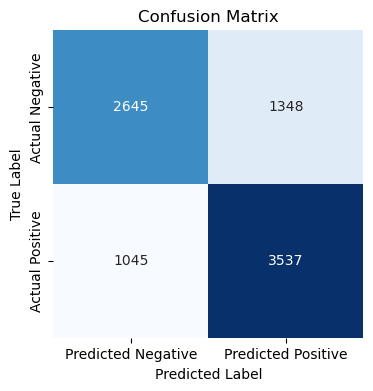

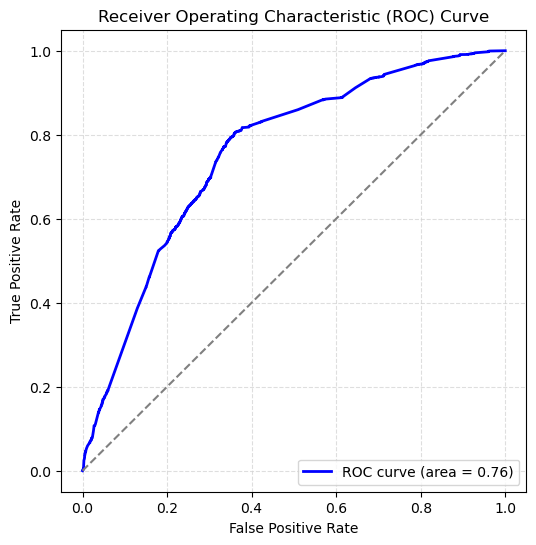

In [5]:
lr = LogisticRegression()
doClassification(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix:
    [[ 9317  2728]
 [ 2316 11363]]

    AUC: 0.8781197820112585

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      0.77      0.79     12045
           1       0.81      0.83      0.82     13679

    accuracy                           0.80     25724
   macro avg       0.80      0.80      0.80     25724
weighted avg       0.80      0.80      0.80     25724

    
TEST METRICS
    Confusion Matrix:
    [[2736 1257]
 [1150 3432]]

    AUC: 0.7469082188023717

    Classification Report:
                  precision    recall  f1-score   support

           0       0.70      0.69      0.69      3993
           1       0.73      0.75      0.74      4582

    accuracy                           0.72      8575
   macro avg       0.72      0.72      0.72      8575
weighted avg       0.72      0.72      0.72      8575

    


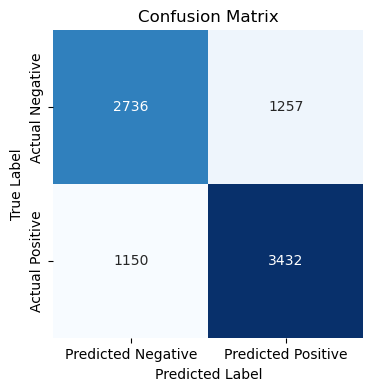

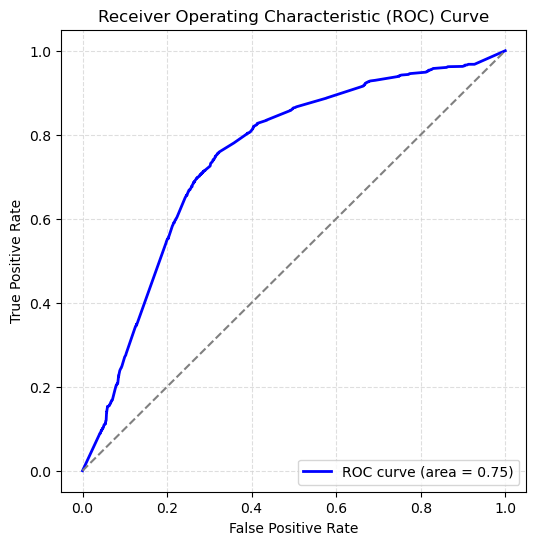

In [6]:
et = ExtraTreesClassifier(random_state=42)
doClassification(et, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix:
    [[ 8074  3971]
 [ 3326 10353]]

    AUC: 0.7572644265899702

    Classification Report:
                  precision    recall  f1-score   support

           0       0.71      0.67      0.69     12045
           1       0.72      0.76      0.74     13679

    accuracy                           0.72     25724
   macro avg       0.72      0.71      0.71     25724
weighted avg       0.72      0.72      0.72     25724

    
TEST METRICS
    Confusion Matrix:
    [[2652 1341]
 [1093 3489]]

    AUC: 0.7542400422913822

    Classification Report:
                  precision    recall  f1-score   support

           0       0.71      0.66      0.69      3993
           1       0.72      0.76      0.74      4582

    accuracy                           0.72      8575
   macro avg       0.72      0.71      0.71      8575
weighted avg       0.72      0.72      0.72      8575

    


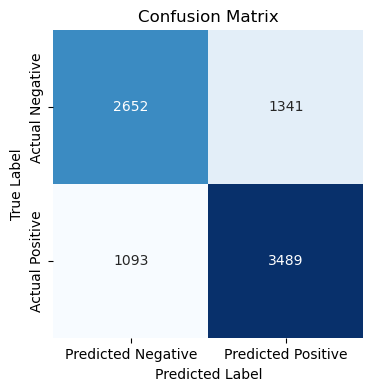

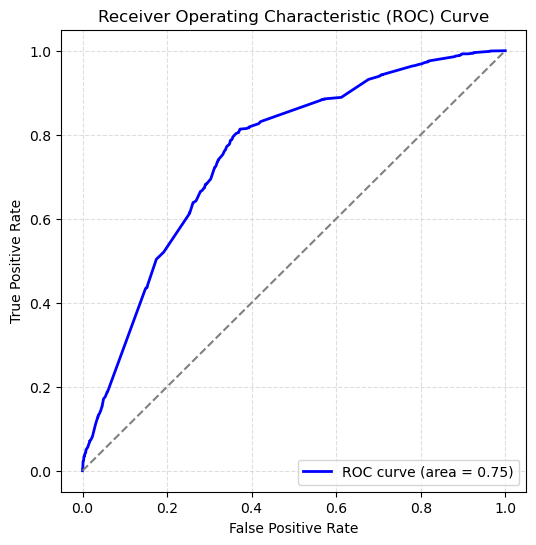

In [7]:
ada = AdaBoostClassifier(random_state=42)
doClassification(ada, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix:
    [[ 8437  3608]
 [ 2691 10988]]

    AUC: 0.8187777175601728

    Classification Report:
                  precision    recall  f1-score   support

           0       0.76      0.70      0.73     12045
           1       0.75      0.80      0.78     13679

    accuracy                           0.76     25724
   macro avg       0.76      0.75      0.75     25724
weighted avg       0.76      0.76      0.75     25724

    
TEST METRICS
    Confusion Matrix:
    [[2656 1337]
 [ 997 3585]]

    AUC: 0.7776791948109103

    Classification Report:
                  precision    recall  f1-score   support

           0       0.73      0.67      0.69      3993
           1       0.73      0.78      0.75      4582

    accuracy                           0.73      8575
   macro avg       0.73      0.72      0.72      8575
weighted avg       0.73      0.73      0.73      8575

    


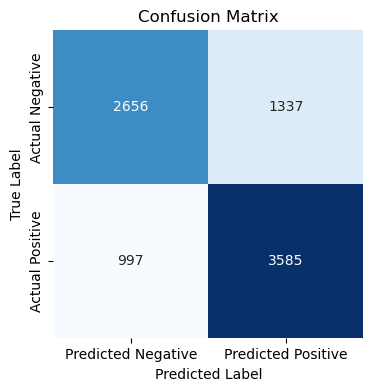

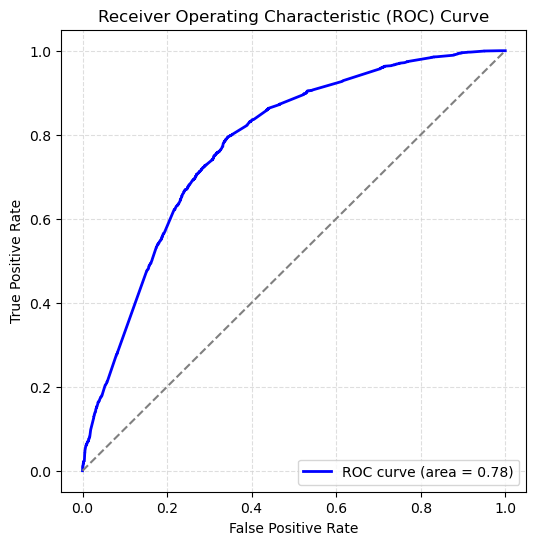

In [8]:
xgb = XGBClassifier(random_state=42)
doClassification(xgb, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 13679, number of negative: 12045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 25724, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531760 -> initscore=0.127212
[LightGBM] [Info] Start training from score 0.127212
TRAIN METRICS
    Confusion Matrix:
    [[ 8121  3924]
 [ 2714 10965]]

    AUC: 0.8038441875085787

    Classification Report:
                  precision    recall  f1-score   support

           0       0.75      0.67      0.71     12045
           1       0.74      0.80      0.77     13679

    accuracy                           0.74     25724
   macro avg       0.74      0.74      0.74     25724
weighted avg       0.74      0.74      0.

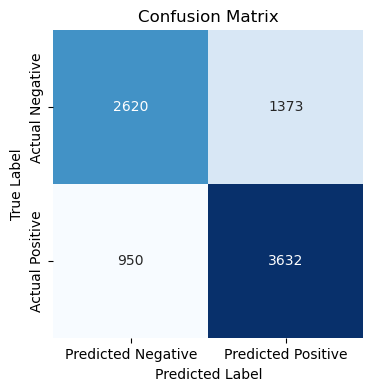

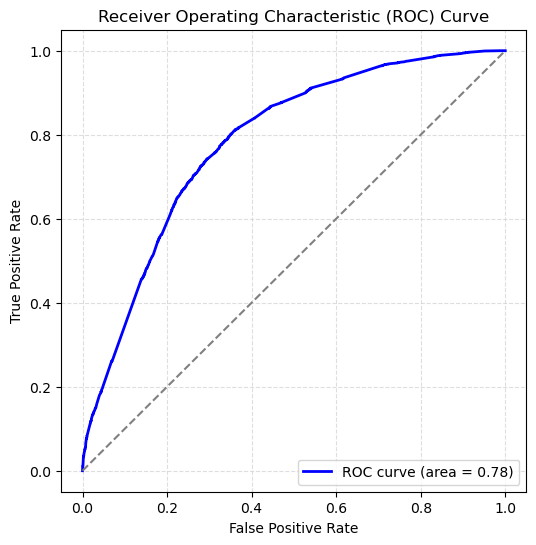

In [9]:
lgbm = LGBMClassifier(random_state=42)
doClassification(lgbm, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix:
    [[ 9047  2998]
 [ 2393 11286]]

    AUC: 0.8555578902142528

    Classification Report:
                  precision    recall  f1-score   support

           0       0.79      0.75      0.77     12045
           1       0.79      0.83      0.81     13679

    accuracy                           0.79     25724
   macro avg       0.79      0.79      0.79     25724
weighted avg       0.79      0.79      0.79     25724

    
TEST METRICS
    Confusion Matrix:
    [[2703 1290]
 [1103 3479]]

    AUC: 0.7587584252363067

    Classification Report:
                  precision    recall  f1-score   support

           0       0.71      0.68      0.69      3993
           1       0.73      0.76      0.74      4582

    accuracy                           0.72      8575
   macro avg       0.72      0.72      0.72      8575
weighted avg       0.72      0.72      0.72      8575

    


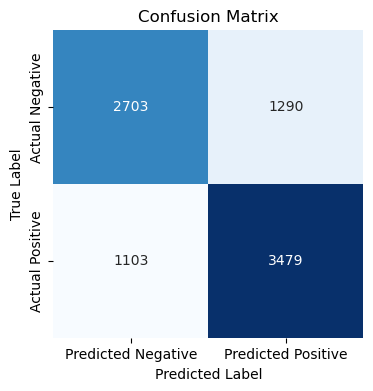

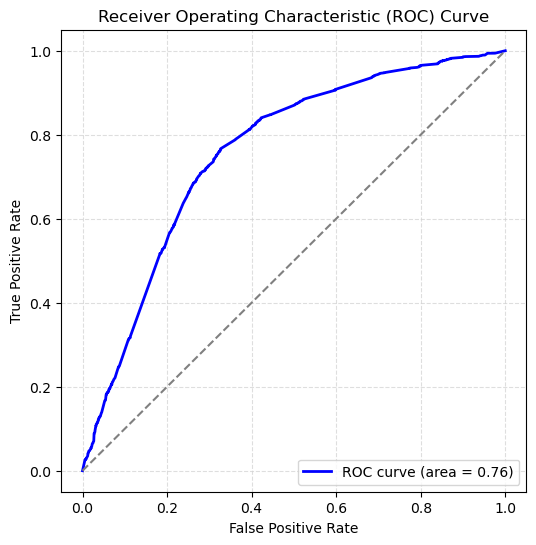

In [10]:
rf = RandomForestClassifier(random_state=42)
doClassification(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix:
    [[ 8000  4045]
 [ 2936 10743]]

    AUC: 0.7847796619828942

    Classification Report:
                  precision    recall  f1-score   support

           0       0.73      0.66      0.70     12045
           1       0.73      0.79      0.75     13679

    accuracy                           0.73     25724
   macro avg       0.73      0.72      0.73     25724
weighted avg       0.73      0.73      0.73     25724

    
TEST METRICS
    Confusion Matrix:
    [[2624 1369]
 [ 981 3601]]

    AUC: 0.7783680366875118

    Classification Report:
                  precision    recall  f1-score   support

           0       0.73      0.66      0.69      3993
           1       0.72      0.79      0.75      4582

    accuracy                           0.73      8575
   macro avg       0.73      0.72      0.72      8575
weighted avg       0.73      0.73      0.72      8575

    


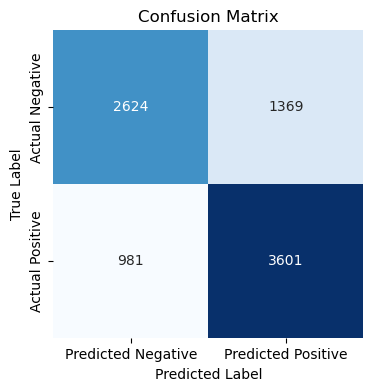

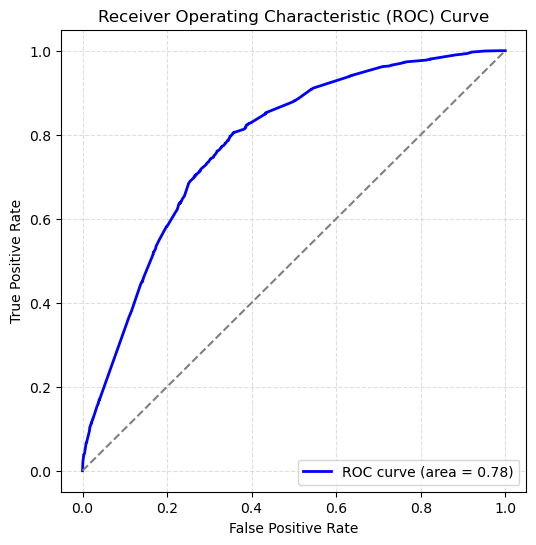

In [11]:
gb = GradientBoostingClassifier(random_state=42)
doClassification(gb, X_train, X_test, y_train, y_test)

In [12]:
# save the best model (lgbm)
pickle.dump(lgbm, open('../models/AlphabetSoupLGBM.pkl', 'wb'))